In [68]:
from IPython.display import display, Javascript, Image
from tensorflow.keras.preprocessing import image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL
import io
import html
import time

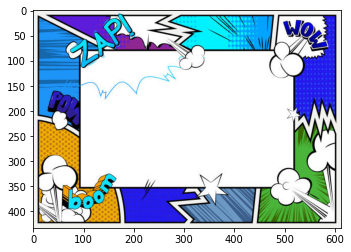

In [69]:
frame = cv2.imread("/content/Frame.png")
plt.imshow(frame)
plt.show()

In [ ]:
def resizing_image_scale(scale_percent, image):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dsize = (width, height)
  return dsize

In [ ]:
def mask_image(final_image, frame):
    for i in range(0,final_image.shape[0]):
      for j in range(0,final_image.shape[1]):
        frame[i+99,j+140] = final_image[i,j]

In [70]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true); // To resize the output to fit the video element.

      await new Promise((resolve) => capture.onclick = resolve); // To wait until the "Capture" button is clicked.

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  
  data = eval_js('takePhoto({})'.format(quality)) # To get photo data
  
  img = js_to_image(data) # To get OpenCV format image
  
  grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  median_filter_image = cv2.medianBlur(grayscale_image, 3)
  laplacian_image = cv2.Laplacian(median_filter_image, cv2.CV_64F)
  thresholding_value = random.randint(1, 5)
  th, black_edges_image = cv2.threshold(laplacian_image, thresholding_value, 255, cv2.THRESH_BINARY_INV)
  bilateral_filter_image = cv2.bilateralFilter(img,9,200,200)
  
  final_image = bilateral_filter_image.copy()



  for i in range(0,final_image.shape[0]):
    for j in range(0,final_image.shape[1]):
      if(black_edges_image[i,j] == 0):
        final_image[i,j] = black_edges_image[i,j]

  desize = resizing_image_scale(50, final_image)
  new_final_image = cv2.resize(final_image, desize)

  mask_image(new_final_image, frame)

  cv2.imwrite(filename, frame) # Save image

  return filename

In [ ]:
try:
  filename = take_photo('CartoonifiedImage.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))